# Notebook to Generate Benchmark Plots

In [1]:
import matplotlib.pyplot as plt
import json
import glob
import numpy as np

plt.style.use("ggplot")

In [18]:
def extract_benchmarks(json_data):
    """
    Aggregates a list of benchmarks into a dictionary
    that maps benchmark_name --> results for different param values.
    """
    benchmarks = dict()
    for benchmark in json_data["benchmarks"]:
        name = benchmark["name"].split("[")[0]
        param_name = list(benchmark["params"].keys())[0]
        param_val = list(benchmark["params"].values())[0]
        if not name in benchmarks:
            benchmarks[name] = {key: [] for key in benchmark["stats"].keys()}
            benchmarks[name]["param_name"] = param_name
            benchmarks[name]["param_val"] = []
        for key_name, key_value in benchmark["stats"].items():
            benchmarks[name][key_name].append(key_value)
        benchmarks[name]["param_val"].append(param_val)
    return benchmarks

def load_benchmark_data_from_json(filename):
    with open(filename, "r") as fp:
        json_data = json.load(fp)
    return extract_benchmarks(json_data)

def plot_series(benchmark_data, color="C0", label=""):
    params = np.array(benchmark_data["param_val"])
    mean_times = np.array(benchmark_data["mean"])
    mask = np.isnan(mean_times)
    m, b = np.polyfit(params[~mask], mean_times[~mask], deg=1)
    ys = np.copy(mean_times)
    ys[mask] = m * params[mask] + b  # replace nans with linear prediction
    for x, y, isnan in zip(params, ys, mask):
        plt.scatter(x, y, marker="x" if isnan else "o", 
                    s=80 if isnan else 40, 
                    color="black" if isnan else color)
    plt.plot(params, m * params + b, '--', color=color, label=label)

def plot_benchmarks(prefix="", jax_prefix="", old_prefix=""):
    """
    By default, will use the latest benchmark file.
    args:
        - prefix: match string of .json report (will take latest from matched files)
        - jax_prefix: use if jax file differs from ssm_v0 file
        - old_prefix: use if ssm_v0 file differs from jax file
    """

    if jax_prefix == "":
        jax_prefix = prefix
    if old_prefix == "":
        old_prefix = prefix

    # get last alphabetically sorted fname [generally, most recent] (with optional prefix) 
    ssm_jax_fname = sorted(glob.glob(f".benchmarks/*/*{jax_prefix}*.json"))[-1]
    ssm_old_fname = sorted(glob.glob(f"ssm_v0_benchmark_tests/.benchmarks/*/*{old_prefix}*.json"))[-1]

    # load-in and pre-process some benchmark data
    jax_benchmarks = load_benchmark_data_from_json(ssm_jax_fname)
    old_benchmarks = load_benchmark_data_from_json(ssm_old_fname)

    # plot the different benchmarks
    for benchmark_name in jax_benchmarks:
        plt.figure(figsize=(8, 6))
        if benchmark_name in jax_benchmarks:
            plot_series(jax_benchmarks[benchmark_name], color="blue", label="SSM-JAX")
        if benchmark_name in old_benchmarks:
            plot_series(old_benchmarks[benchmark_name], color="red", label="SSM-v0")
        plt.scatter([], [], marker="x", color="black", label="Errored")
        plt.title(benchmark_name)
        plt.xlabel(jax_benchmarks[benchmark_name]["param_name"])
        plt.ylabel("time (s)")
        plt.legend()
        plt.show()        

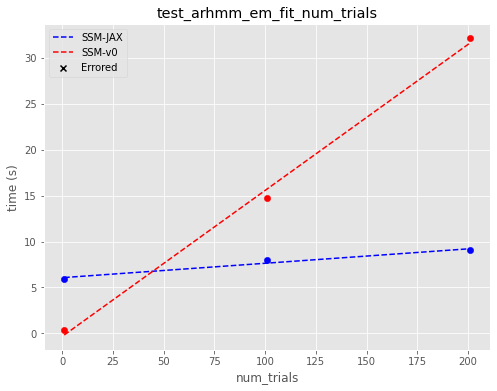

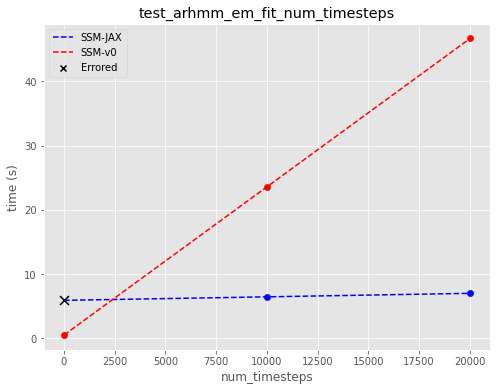

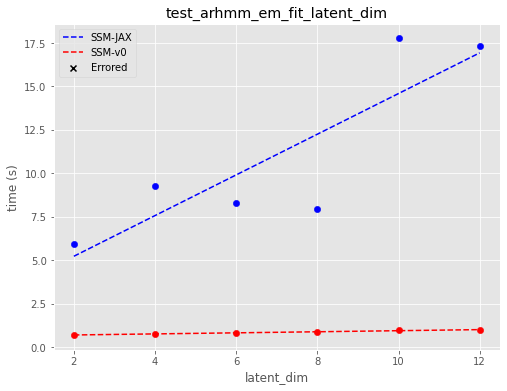

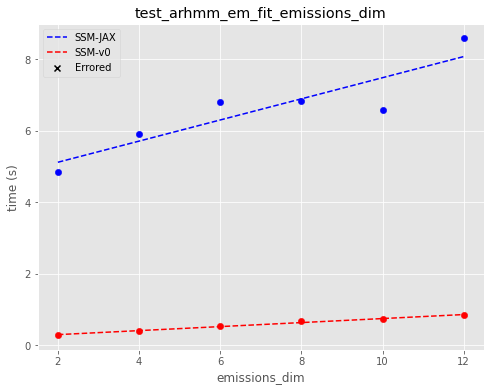

In [20]:
plot_benchmarks(prefix="arhmm")